In [5]:
##Imports needed plugins

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt 
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from itertools import combinations 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import recall_score
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning)

In [10]:
# Import the data
data = pd.read_csv("../data/DataWithLocationCleaned.csv.gz")
df = data.copy()

In [11]:
# Add lagitude and longitude
# Create one dataFrame for persons and one only for traffic
def getlat(x):
    lat = x.partition(',')[0][1:]
    if lat[0] == "'":
        lat = lat[1:-1]
    return lat

def getlong(x):
    lat = x.partition(',')[2]
    if lat[1] == "'":
        lat = lat[2:-2]
    else:
        lat = lat[1:-1]
    return lat

df['latitude'] = df['position'].apply(lambda x: getlat(x))
df['longitude'] = df['position'].apply(lambda x: getlong(x))
persons = df[df['Measure'].isin(['Bus Passengers','Pedestrians','Personal Vehicle Passengers','Train Passengers'])].reset_index().drop(columns=['index'])
traffic = df[~df['Measure'].isin(['Bus Passengers','Pedestrians','Personal Vehicle Passengers','Train Passengers'])].reset_index().drop(columns=['index'])
nozero = persons[persons['Value'] != 0]
ports = df['Port Name'].unique()
persons.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Year,Month,position,latitude,longitude
0,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Personal Vehicle Passengers,19459,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
1,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Pedestrians,2,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
2,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Bus Passengers,63,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
3,Roseau,Minnesota,3426,US-Canada Border,2019-06-01,Personal Vehicle Passengers,7385,2019,6,"(48.7710371, -95.7697882)",48.7710371,-95.7697882
4,Roseau,Minnesota,3426,US-Canada Border,2019-06-01,Bus Passengers,118,2019,6,"(48.7710371, -95.7697882)",48.7710371,-95.7697882


# Logistic regression

In [12]:
def logistic(X,y,baseRate):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    LR = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)
    LR.fit(X_train,y_train)
    test_score = LR.score(X_test, y_test)
    train_score = LR.score(X_train,y_train)
    print("train_score :",train_score,"test_score =",test_score)
    return [train_score,test_score,confusion_matrix(y_train, LR.predict(X_train)),baseRate]

def encodeOneHot(z,f,i):
    test = z
    baseRate = pd.qcut(test['Value'],q = i, duplicates = 'drop').value_counts()
    print("Base rate :",baseRate.max()/baseRate.sum())
    print()
    test['quant'] = pd.qcut(test['Value'],q = i, duplicates = 'drop')
    print("intervalls for y:")
    print(test['quant'].value_counts())
    print()
    le = LabelEncoder()
    y = le.fit_transform(test["quant"])
    one_hot = OneHotEncoder(categories="auto")
    
    categoricals = []
    for feature in f:
        if feature in ['Measure','State','Border']:
            f.remove(feature)
            categoricals.append(feature)
            
    cat_to_onehot = one_hot.fit_transform(test[categoricals]).toarray()
    cat_to_onehot = pd.DataFrame(cat_to_onehot)
    X = pd.concat((test[f],cat_to_onehot),axis=1)
    return logistic(X,y,baseRate.max()/baseRate.sum())

def  computeLogistic(dataset,ports,f,i):
    if (len(f) == 0):
        return
    Zone = dataset[dataset['Port Name'].isin(ports)].reset_index(drop=True)
    return encodeOneHot(Zone,f,i)


In [8]:
#Logistic regression on persons with all variables
persons_logistic = computeLogistic(persons,ports,['Measure','Port Code','Month','Year','State','latitude','longitude','Border'],8),

Base rate : 0.37606668331453275

intervalls for y:
(-0.001, 11.0]          43673
(62918.0, 4447374.0]    14516
(6943.0, 62918.0]       14516
(1193.0, 6943.0]        14516
(156.0, 1193.0]         14503
(11.0, 156.0]           14407
Name: quant, dtype: int64

train_score : 0.5278028933092225 test_score = 0.5279631463383132


We can see that the intervalls are biaised. So the results are not relevant. 

As we have seen in our EDA, we'll take only non-null values.

## Find a good number of intervalls

In [30]:
test = []
for i in range(2,10):
    test.append([i,computeLogistic(nozero,ports,['Measure','Port Code','State','latitude','longitude'],i)])

Base rate : 0.5000396699460489

intervalls for y:
(0.999, 2394.0]        37815
(2394.0, 4447374.0]    37809
Name: quant, dtype: int64

train_score : 0.8240301492586655 test_score = 0.8186446280991736
Base rate : 0.3335977996403258

intervalls for y:
(0.999, 501.0]            25228
(11238.333, 4447374.0]    25208
(501.0, 11238.333]        25188
Name: quant, dtype: int64

train_score : 0.6949205771996231 test_score = 0.6955371900826446
Base rate : 0.2500925632074474

intervalls for y:
(0.999, 190.0]          18913
(32053.0, 4447374.0]    18906
(2394.0, 32053.0]       18903
(190.0, 2394.0]         18902
Name: quant, dtype: int64

train_score : 0.5718276335146035 test_score = 0.5843966942148761
Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5208019967272186 test_score = 0.5289256198347108
Base ra

In [43]:
intervalls_testError = []
for i in range(0,len(test)):
    intervalls_testError.append([test[i][0],test[i][1][0],test[i][1][1],test[i][1][3]])
print(intervalls_testError)

[[2, 0.8240301492586655, 0.8186446280991736, 0.5000396699460489], [3, 0.6949205771996231, 0.6955371900826446, 0.3335977996403258], [4, 0.5718276335146035, 0.5843966942148761, 0.2500925632074474], [5, 0.5208019967272186, 0.5289256198347108, 0.20034645086216016], [6, 0.46418949073538407, 0.47206611570247936, 0.16703691949645616], [7, 0.40281657548058647, 0.40826446280991735, 0.14404157410345922], [8, 0.3822873105340584, 0.39404958677685953, 0.12650745794985718], [9, 0.34703052943023854, 0.3504793388429752, 0.11221305405691315]]


In [47]:
intervalls_testError = pd.DataFrame(intervalls_testError)
intervalls_testError = intervalls_testError.rename(columns={0:"intervalls",1: "train_error",2:"testerror",3:"baserate"})
intervalls_testError['diff'] = intervalls_testError['testerror']-intervalls_testError['baserate']
intervalls_testError

,intervalls,train_error,testerror,baserate,diff
0,2,0.824030,0.818645,0.500040,0.318605
1,3,0.694921,0.695537,0.333598,0.361939
2,4,0.571828,0.584397,0.250093,0.334304
3,5,0.520802,0.528926,0.200346,0.328579
4,6,0.464189,0.472066,0.167037,0.305029
5,7,0.402817,0.408264,0.144042,0.264223
6,8,0.382287,0.394050,0.126507,0.267542
7,9,0.347031,0.350479,0.112213,0.238266


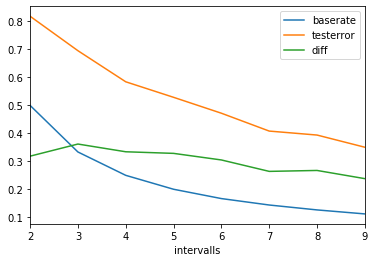

In [48]:
intervalls_testError.plot(x="intervalls", y=["baserate","testerror","diff"])

Intervall = 5 is a good compromise between performance and sufficient number of observations in an intervall.

## Find the best combinations of parameters

In [52]:
L1 = computeLogistic(nozero,ports,['Measure'],5)

Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.36977470701995074 test_score = 0.3703801652892562


In [53]:
L2 = computeLogistic(nozero,ports,['Port Code'],5)

Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.245888361791104 test_score = 0.23735537190082645


In [54]:
L3 = computeLogistic(nozero,ports,['Measure','Port Code'],5)

Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.44347840460172894 test_score = 0.4432396694214876


In [56]:
L4 = computeLogistic(nozero,ports,['Measure','Port Code','Month'],5)

Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.44362716739119656 test_score = 0.44502479338842976


In [57]:
L5 = computeLogistic(nozero,ports,['Measure','Port Code','Year'],5)


Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.45207358799319 test_score = 0.45269421487603306


In [58]:
L6 = computeLogistic(nozero,ports,['Measure','Port Code','Year','Month'],5)

Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.4442387477478967 test_score = 0.44469421487603306


In [59]:
L7 = computeLogistic(nozero,ports,['Measure','Port Code','State'],5)

Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5192151936395643 test_score = 0.5215206611570248


In [60]:
L8 = computeLogistic(nozero,ports,['Measure','Port Code','State','latitude'],5)

Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5241574240896544 test_score = 0.5265454545454545


In [61]:
L9 = computeLogistic(nozero,ports,['Measure','Port Code','State','latitude','longitude'],5)

Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5242731284814625 test_score = 0.5268099173553719


In [62]:
L10 = computeLogistic(nozero,ports,['Measure','Port Code','State','latitude','longitude','Border'],5)

Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5279591398204929 test_score = 0.5302479338842975


In [63]:
L11 = computeLogistic(nozero,ports,['Measure','Port Code','State','Year','latitude','longitude'],5)

Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5219425114464702 test_score = 0.5254214876033058


The best combinations (L10) of parameters are ['Measure','Port Code','State','latitude','longitude','Border'] for a test score of 0.53


In [64]:
L12 = computeLogistic(nozero.sort_values(by=['Date']).reset_index(drop=True),ports,['Measure','Port Code','State','latitude','longitude','Border'],5)

Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5171986313823369 test_score = 0.5261487603305786


If we sort the values by Date that doesn't help to improve our test score

In [84]:
#Plot the confusion matrix for l10
L10[2]

array([[ 8946,  2749,   107,   136,   127],
       [ 4087,  5353,  1655,   578,   422],
       [ 2825,  1757,  4348,  1186,  2036],
       [  894,   821,  3621,  2723,  4062],
       [   39,   125,   451,   880, 10571]])

## Logistic regression on ports

In [13]:
#We create a list of "goods" port : these port will have more than 800 values not equal to 0.
error_port= []
for port in ports:
    if (nozero[(nozero['Port Name'] == port)].shape[0]>800):
        error_port.append([port,computeLogistic(nozero,[port],['Measure','Port Code','State','latitude','Year','Month','longitude','Border'],5)])

Base rate : 0.20039486673247778

intervalls for y:
(14014.0, 49762.0]    203
(500.8, 1297.6]       203
(0.999, 88.4]         203
(1297.6, 14014.0]     202
(88.4, 500.8]         202
Name: quant, dtype: int64

train_score : 0.6851851851851852 test_score = 0.6699507389162561
Base rate : 0.2

intervalls for y:
(650030.8, 2473401.0]    173
(74705.0, 650030.8]      173
(16619.6, 74705.0]       173
(917.4, 16619.6]         173
(359.999, 917.4]         173
Name: quant, dtype: int64

train_score : 0.8005780346820809 test_score = 0.8034682080924855
Base rate : 0.2

intervalls for y:
(110083.2, 307761.0]    224
(4109.4, 110083.2]      224
(2459.4, 4109.4]        224
(305.4, 2459.4]         224
(2.999, 305.4]          224
Name: quant, dtype: int64

train_score : 0.625 test_score = 0.6383928571428571
Base rate : 0.200734394124847

intervalls for y:
(118028.4, 1507021.0]    164
(1465.6, 2250.0]         164
(3.999, 939.2]           164
(939.2, 1465.6]          163
(2250.0, 118028.4]       162
Name: q

train_score : 0.7691415313225058 test_score = 0.8055555555555556
Base rate : 0.20024721878862795

intervalls for y:
(460055.6, 797199.0]    162
(259895.8, 460055.6]    162
(101.6, 180451.6]       162
(0.999, 101.6]          162
(180451.6, 259895.8]    161
Name: quant, dtype: int64

train_score : 0.58887171561051 test_score = 0.5802469135802469
Base rate : 0.20884289746001883

intervalls for y:
(15.999, 133.0]         222
(459547.4, 898363.0]    213
(983.2, 8768.0]         213
(8768.0, 459547.4]      212
(133.0, 983.2]          203
Name: quant, dtype: int64

train_score : 0.6517647058823529 test_score = 0.6572769953051644
Base rate : 0.21422222222222223

intervalls for y:
(5.999, 42.0]            241
(686050.8, 1252553.0]    225
(127240.2, 686050.8]     225
(18992.2, 127240.2]      225
(42.0, 18992.2]          209
Name: quant, dtype: int64

train_score : 0.7988888888888889 test_score = 0.7866666666666666
Base rate : 0.20024875621890548

intervalls for y:
(2097779.0, 3755585.0]    161
(7

In [14]:
port_localisation = []
for i in range(0,len(error_port)):
    port_localisation.append([error_port[i][0],error_port[i][1][0],error_port[i][1][1]])

Plot the test_score of every of these ports on the map of the USA

In [26]:
port_localisation =  pd.DataFrame(data = port_localisation,columns = ['Port Name','Train Score','Test Score'])
ps = nozero[['Port Name','latitude']].drop_duplicates().set_index('Port Name')
port_localisation['latitude'] = port_localisation['Port Name'].apply(lambda x : ', '.join(ps.loc[x].values.flatten()))
ps = nozero[['Port Name','longitude']].drop_duplicates().set_index('Port Name')
port_localisation['longitude'] = port_localisation['Port Name'].apply(lambda x : ', '.join(ps.loc[x].values.flatten()))
port_localisation['text'] = port_localisation['Port Name'] + '<br>Test Score: ' + (port_localisation['Test Score']).astype(str)



fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = port_localisation['longitude'],
        lat = port_localisation['latitude'],
        text = port_localisation['text'],
        mode = 'markers',
        marker = dict(
            size = 10,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Greens',
            cmin = 0,
            color = port_localisation['Test Score'],
            cmax = port_localisation['Test Score'].max(),
            colorbar_title="Incoming flights<br>February 2011"
        )))

fig.update_layout(
        title = 'Most trafficked US airports<br>(Hover for airport names)',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

# Linear Regression

TO DO : Create a linear regression with the logValue for y. (see notebook linear_regression)

In [51]:
y = np.log(nozero['Value']+1)

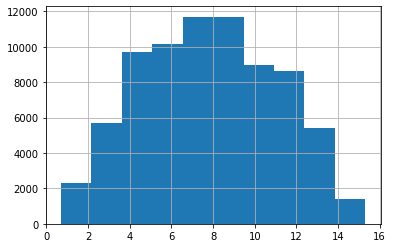

In [52]:
y.hist()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(El_Paso[['longitude']], y, test_size=0.2, random_state=42)
iowa_model = LinearRegression()
iowa_model.fit(X_train,y_train)
test_score = iowa_model.score(X_test, y_test)
train_score = iowa_model.score(X_train,y_train)
print("train_score :",train_score,"test_score =",test_score)

train_score : 0.0 test_score = -0.008303422707893748


In [26]:
El_Paso = nozero[nozero['Port Name']== 'El Paso']